# Load Quantum Feature Importance

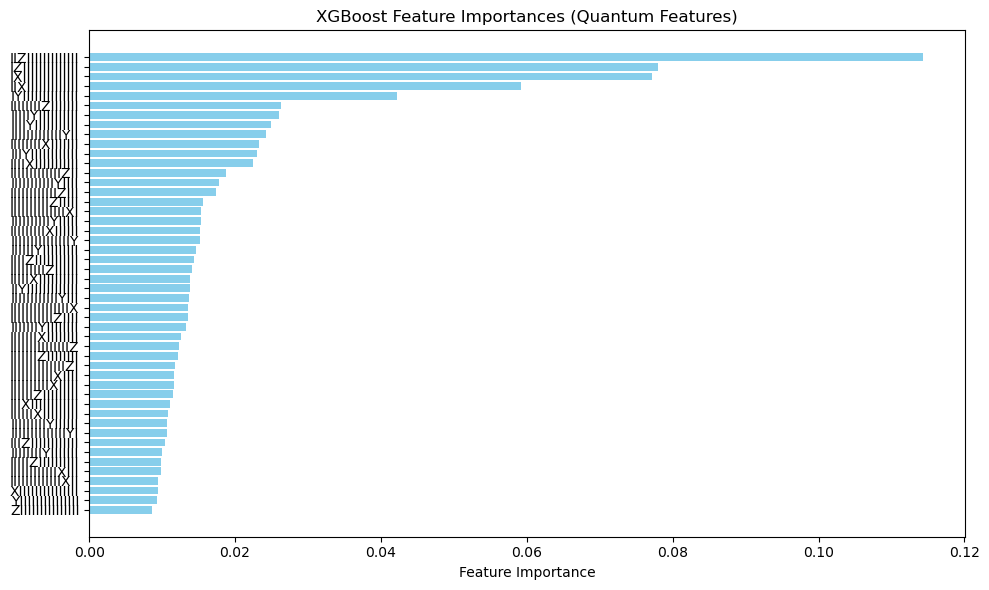

In [3]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

######################################
# PART 1: Load Quantum Model & Importances
######################################

# Parameters for model file and data file (quantum)
res_dir = "qp_model_results"
model_name = "qp_model"
backend_name = "quantum"
model_path = f"{res_dir}/{model_name}_{backend_name}.pkl"
quantum_data_file = "data_homiris_quantum/QX_train_int_sample.pkl"  # Quantum training data file

# Load the saved best quantum model (a pipeline)
with open(model_path, "rb") as f:
    best_model = pickle.load(f)

# Extract the XGBClassifier step from the pipeline
xgb_model = best_model.named_steps["xgb"]

# Get the quantum feature importances from the XGBoost model
quantum_importances = xgb_model.feature_importances_

# Load the quantum dataset to obtain quantum feature names.
df_quantum = pd.read_pickle(quantum_data_file)
if df_quantum.columns is None or len(df_quantum.columns) == 0:
    quantum_feature_names = [f"feature_{i}" for i in range(df_quantum.shape[1])]
else:
    quantum_feature_names = df_quantum.columns.tolist()

# Create a DataFrame for plotting the quantum feature importances
importance_df_quantum = pd.DataFrame({
    "feature": quantum_feature_names,
    "importance": quantum_importances
}).sort_values(by="importance", ascending=False)

# Plot horizontal bar chart of quantum feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df_quantum["feature"], importance_df_quantum["importance"], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importances (Quantum Features)")
plt.gca().invert_yaxis()  # Most important features on top
plt.tight_layout()
plt.show()


# Create approximated sensitivity matrix

In [52]:
import os
import time
import pickle
import numpy as np
import pandas as pd

#############################################
# Helper Function 1: Select k indices per quantum feature
#############################################
def select_indices_from_dataframe(df, k):
    """
    For each column (quantum feature) in the DataFrame,
    select k sample indices based on the following rule:
      - k == 1: select the index of the value closest to the mean.
      - k == 2: select the indices corresponding to the minimum and maximum.
      - k >= 3: select indices corresponding to evenly spaced quantiles (including min and max).
    
    Parameters:
      df : pd.DataFrame
          DataFrame containing quantum features (columns) and samples (rows).
      k : int
          Number of points to select per quantum feature.
    
    Returns:
      indices_dict : dict
          Dictionary mapping each column name to a list of selected row indices.
    """
    indices_dict = {}
    n_samples = df.shape[0]
    
    for col in df.columns:
        values = df[col].values
        if k == 1:
            # Select index closest to the mean
            mean_val = np.mean(values)
            idx = int(np.argmin(np.abs(values - mean_val)))
            indices = [idx]
        elif k == 2:
            # Select indices of the minimum and maximum values
            idx_min = int(np.argmin(values))
            idx_max = int(np.argmax(values))
            indices = [idx_min, idx_max]
        else:
            # For k >= 3, select indices at evenly spaced quantiles from 0 to 1
            quantiles = np.linspace(0, 1, k)
            sorted_idx = np.argsort(values)
            indices = []
            for q in quantiles:
                pos = int(round(q * (n_samples - 1)))
                indices.append(int(sorted_idx[pos]))
        indices_dict[col] = indices
    return indices_dict

#############################################
# Helper Function 2: Compute approximate sensitivity matrix
#############################################
def compute_approx_sensitivity_matrix(alpha, k, output_dir, df_quantum):
    """
    Compute an approximate sensitivity matrix by selecting k points (per quantum feature)
    from the saved QX_plus and QX_minus files in each theta folder.
    """
    # Get selection indices per quantum feature from the unshifted data
    indices_dict = select_indices_from_dataframe(df_quantum, k)
    
    quantum_feature_names = df_quantum.columns.tolist()
    n_quantum_features = len(quantum_feature_names)
    
    theta_dirs = [d for d in os.listdir(output_dir) if d.startswith("theta_")]
    theta_dirs.sort(key=lambda x: int(x.split('_')[1]))
    n_features = len(theta_dirs)
    
    S = np.zeros((n_features, n_quantum_features))
    
    for i, theta_dir in enumerate(theta_dirs):
        #print(f"\nProcessing feature theta_{i}...")
        theta_path = os.path.join(output_dir, theta_dir)
        
        with open(os.path.join(theta_path, "QX_plus.pkl"), "rb") as f:
            QX_plus = pickle.load(f)
        with open(os.path.join(theta_path, "QX_minus.pkl"), "rb") as f:
            QX_minus = pickle.load(f)
        
        # If QX_plus/QX_minus are DataFrames, use .iloc for indexing
        for j, col in enumerate(quantum_feature_names):
            selected_indices = indices_dict[col]
            # Use .iloc if these are DataFrames; otherwise, if they're numpy arrays, the original indexing works.
            if isinstance(QX_plus, pd.DataFrame):
                dQX = alpha * (QX_plus.iloc[selected_indices, j] - QX_minus.iloc[selected_indices, j])
            else:
                dQX = alpha * (QX_plus[selected_indices, j] - QX_minus[selected_indices, j])
            sensitivity = np.mean(np.abs(dQX))
            S[i, j] = sensitivity
            
    return S

alpha = 0.1  
k = 100      
shifted_data_dir = "shifted_data"  # This directory contains subfolders 'theta_0', 'theta_1', ...

# Start the timer
start_time = time.time()

# Compute the approximate sensitivity matrix
S_approx = compute_approx_sensitivity_matrix(alpha, k, shifted_data_dir, df_quantum)

# End the timer
end_time = time.time()

# Print execution time in seconds
elapsed_time = end_time - start_time
print(f"Execution Time: {elapsed_time:.4f} seconds")


# (Optional) Convert to DataFrame for easier inspection
S_approx_df = pd.DataFrame(S_approx,
                           index=[f"theta_{i}" for i in range(S_approx.shape[0])],
                           columns=quantum_feature_names)


Execution Time: 0.2504 seconds


In [54]:
0.2504*1000/60

4.173333333333334

In [46]:
print(S_approx_df.shape)

(20, 48)


In [48]:
S_approx_df.head()

,IIIIIIIIIIIIIIIX,IIIIIIIIIIIIIIIY,IIIIIIIIIIIIIIIZ,IIIIIIIIIIIIIIXI,IIIIIIIIIIIIIIYI,IIIIIIIIIIIIIIZI,IIIIIIIIIIIIIXII,IIIIIIIIIIIIIYII,IIIIIIIIIIIIIZII,IIIIIIIIIIIIXIII,...,IIIZIIIIIIIIIIII,IIXIIIIIIIIIIIII,IIYIIIIIIIIIIIII,IIZIIIIIIIIIIIII,IXIIIIIIIIIIIIII,IYIIIIIIIIIIIIII,IZIIIIIIIIIIIIII,XIIIIIIIIIIIIIII,YIIIIIIIIIIIIIII,ZIIIIIIIIIIIIIII
theta_0,0.040611,0.050833,0.076050,0.043451,0.049092,0.076438,0.003446,0.001940,0.000838,0.000328,...,0.000011,0.000012,0.000011,0.000011,0.000012,0.000012,0.000010,0.000012,0.000011,0.000011
theta_1,0.000578,0.000553,0.000339,0.004077,0.002883,0.000526,0.016371,0.074311,0.017625,0.018228,...,0.000011,0.000012,0.000011,0.000010,0.000012,0.000011,0.000011,0.000012,0.000011,0.000009
theta_2,0.000010,0.000011,0.000011,0.000011,0.000011,0.000011,0.000436,0.001053,0.000130,0.007860,...,0.000010,0.000010,0.000011,0.000010,0.000011,0.000012,0.000011,0.000011,0.000009,0.000011
theta_3,0.000012,0.000010,0.000013,0.000011,0.000012,0.000011,0.000013,0.000010,0.000011,0.000010,...,0.000011,0.000011,0.000012,0.000012,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011
theta_4,0.000011,0.000011,0.000011,0.000010,0.000012,0.000011,0.000013,0.000011,0.000011,0.000011,...,0.000011,0.000011,0.000010,0.000010,0.000010,0.000011,0.000013,0.000012,0.000010,0.000011


# Plot Sensitivity Matrix

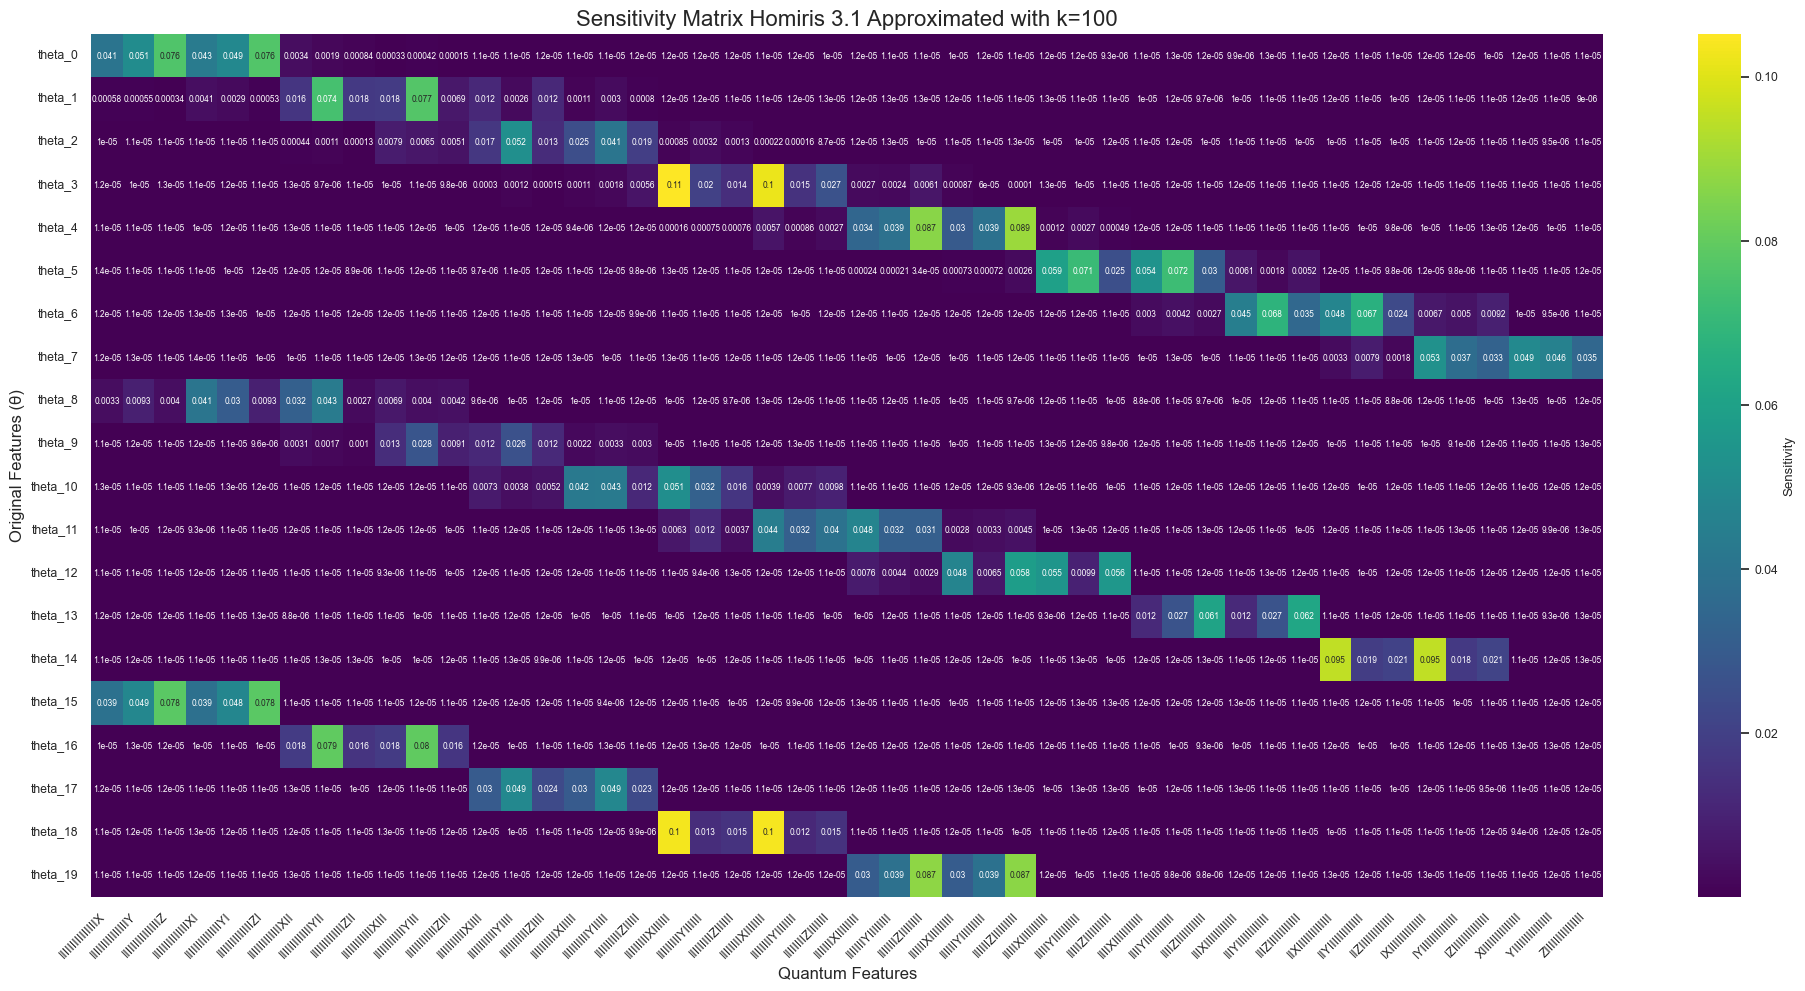

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sensitivity_heatmap(S_df, title="Sensitivity Matrix", 
                             figsize=(20, 10), font_scale=0.8, 
                             annot=True, annot_fontsize=6):
    """
    Plot a heatmap of the sensitivity matrix with adjustable figure size, 
    font scale, and annotation parameters.
    
    Parameters:
    -----------
    S_df : pd.DataFrame
        The sensitivity matrix (features vs. quantum observables).
    title : str
        Title of the heatmap.
    figsize : tuple
        Size of the figure (width, height).
    font_scale : float
        Scale factor for overall fonts (Seaborn's set).
    annot : bool
        Whether to annotate the heatmap cells with numeric values.
    annot_fontsize : int
        Font size for annotations.
    """
    # Set up figure and font scaling
    plt.figure(figsize=figsize)
    sns.set(font_scale=font_scale)

    # Plot the heatmap
    ax = sns.heatmap(
        S_df, 
        annot=annot, 
        cmap="viridis", 
        fmt=".2g",  # 2 significant digits
        cbar_kws={'label': 'Sensitivity'},
        annot_kws={"size": annot_fontsize}
    )

    # Rotate x-axis labels if needed
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)

    # Set labels and title
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Quantum Features", fontsize=12)
    ax.set_ylabel("Original Features (θ)", fontsize=12)

    # Ensure everything fits
    plt.tight_layout()
    plt.show()

# Example usage:
plot_sensitivity_heatmap(S_approx_df, title=f"Sensitivity Matrix Homiris 3.1 Approximated with k={k}")


# Backpropagate feature importance

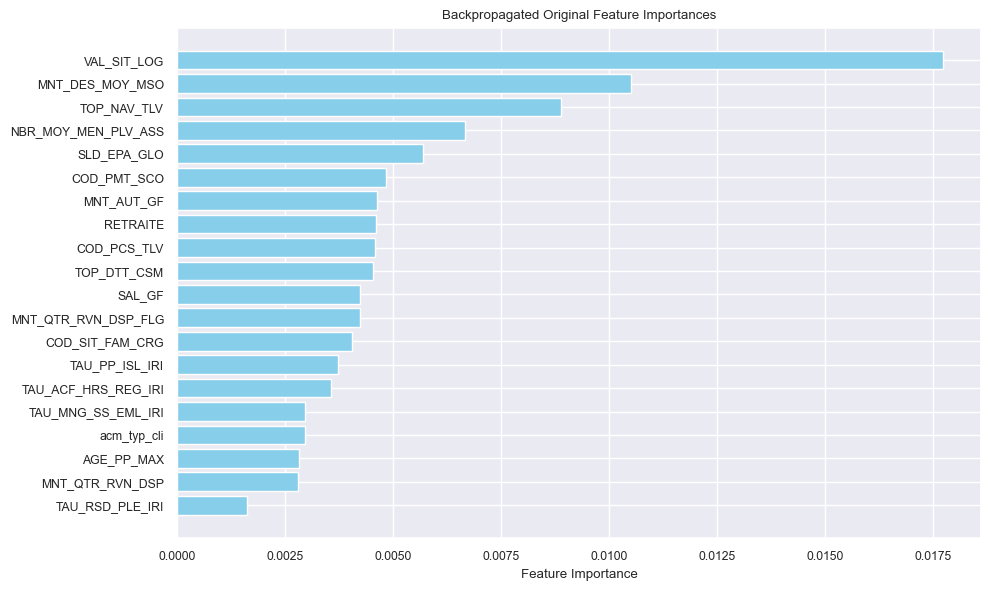

In [37]:

backprop_importances = S_approx_df.dot(quantum_importances)

#print("\nBackpropagated Feature Importances:")
#print(backprop_importances)

# Optionally, load the original dataset (used in your classical model) to get original feature names
orig_data_file = "data_homiris/X_train_int_sample.csv"  # Adjust path as needed
df_orig = pd.read_csv(orig_data_file, delimiter=';', dtype=float)
original_feature_names = df_orig.columns.tolist()

importance_df_orig = pd.DataFrame({
    "feature": original_feature_names,
    "importance": backprop_importances.values
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df_orig["feature"], importance_df_orig["importance"], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Backpropagated Original Feature Importances")
plt.gca().invert_yaxis()  # Most important features on top
plt.tight_layout()
plt.show()


# Run k from 1 up to 10 000

In [55]:
import os
import time
import pickle
import pandas as pd

alpha = 0.1  
  
shifted_data_dir = "shifted_data"  

# Create a folder to store all results (if it doesn't exist already)
results_folder = "sensitivity_results"
os.makedirs(results_folder, exist_ok=True)

# Loop over k values from 1 to 10,000 in steps of 10
for k_val in range(1, 10001, 10):
    start_time = time.time()
    print(f"\nComputing for k = {k_val} ...")
    
    # Compute the approximate sensitivity matrix
    S_approx = compute_approx_sensitivity_matrix(alpha, k_val, shifted_data_dir, df_quantum)
    S_approx_df = pd.DataFrame(S_approx,
                               index=[f"theta_{i}" for i in range(S_approx.shape[0])],
                               columns=quantum_feature_names)
    
    # Compute backpropagated feature importances
    backprop_importances = S_approx_df.dot(quantum_importances)
    
    # Save both results in a dictionary
    results_dict = {
        "S_approx": S_approx_df,
        "backprop_importances": backprop_importances
    }
    
    # Build filename that includes the k value
    filename = f"results_k_{k_val}.pkl"
    filepath = os.path.join(results_folder, filename)
    
    # Save the dictionary as a pickle file
    with open(filepath, "wb") as f:
        pickle.dump(results_dict, f)
    
    elapsed_time = time.time() - start_time
    print(f"Finished k = {k_val} in {elapsed_time:.2f} seconds; file saved as: {filename}")



Computing for k = 1 ...
Finished k = 1 in 0.22 seconds; file saved as: results_k_1.pkl

Computing for k = 11 ...
Finished k = 11 in 0.22 seconds; file saved as: results_k_11.pkl

Computing for k = 21 ...
Finished k = 21 in 0.22 seconds; file saved as: results_k_21.pkl

Computing for k = 31 ...
Finished k = 31 in 0.23 seconds; file saved as: results_k_31.pkl

Computing for k = 41 ...
Finished k = 41 in 0.22 seconds; file saved as: results_k_41.pkl

Computing for k = 51 ...
Finished k = 51 in 0.23 seconds; file saved as: results_k_51.pkl

Computing for k = 61 ...
Finished k = 61 in 0.23 seconds; file saved as: results_k_61.pkl

Computing for k = 71 ...
Finished k = 71 in 0.23 seconds; file saved as: results_k_71.pkl

Computing for k = 81 ...
Finished k = 81 in 0.24 seconds; file saved as: results_k_81.pkl

Computing for k = 91 ...
Finished k = 91 in 0.23 seconds; file saved as: results_k_91.pkl

Computing for k = 101 ...
Finished k = 101 in 0.23 seconds; file saved as: results_k_101.pkl

# Analysis plots

In [56]:
import os
import glob
import pickle
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

def compute_distance_metrics(S_ref, results_folder, quantum_importances):
    """
    Compute distance metrics between the approximated results and the reference results.

    For each approximated result file in the results_folder (expected to be named 
    "results_k_{k}.pkl"), this function computes:
      - The relative Frobenius norm distance between the approximated sensitivity matrix and S_ref.
      - The relative L2 norm distance between the approximated backpropagated importances and the 
        reference backpropagated importances (computed as S_ref.dot(quantum_importances)).
      - The "order distance", defined as 1 minus the Spearman rank correlation between the 
        approximated and reference backpropagated importances.

    Parameters:
      S_ref : pd.DataFrame
          Reference sensitivity matrix computed with the complete dataset.
      results_folder : str
          Folder containing the approximated results files (each a pickle file with a dictionary 
          having keys "S_approx" and "backprop_importances").
      quantum_importances : np.ndarray
          Vector of quantum importances used to compute the reference backpropagated importances.

    Returns:
      metrics : dict
          Dictionary containing:
            "k_values":      np.array of k values,
            "sensitivity_distances": np.array of relative Frobenius norm distances,
            "backprop_distances":    np.array of relative L2 norm distances,
            "order_distances":       np.array of order distances (1 - Spearman correlation).
    """
    # Compute the reference backpropagated importances
    backprop_ref = S_ref.dot(quantum_importances)
    
    # Find all result files in the results_folder (expected name: results_k_{k}.pkl)
    files = glob.glob(os.path.join(results_folder, "results_k_*.pkl"))
    
    # Helper function: extract integer k from filename (assumes format "results_k_{k}.pkl")
    def extract_k(filename):
        basename = os.path.basename(filename)
        k_str = basename.split('_')[2].split('.')[0]
        return int(k_str)
    
    # Sort files by k
    files.sort(key=extract_k)
    
    # Initialize lists to hold the results
    k_values = []
    sensitivity_distances = []
    backprop_distances = []
    order_distances = []
    
    # Loop over each file and compute the distances
    for file in files:
        k = extract_k(file)
        with open(file, "rb") as f:
            results_dict = pickle.load(f)
        S_approx_df = results_dict["S_approx"]
        backprop_approx = results_dict["backprop_importances"]
        
        # 1. Sensitivity Matrix Distance (relative Frobenius norm)
        diff_S = S_approx_df - S_ref
        norm_diff_S = np.linalg.norm(diff_S.values, 'fro')
        norm_S_ref = np.linalg.norm(S_ref.values, 'fro')
        sens_distance = norm_diff_S / norm_S_ref
        
        # 2. Backpropagated Importances Distance (relative L2 norm)
        diff_bp = backprop_approx - backprop_ref
        bp_distance = np.linalg.norm(diff_bp) / np.linalg.norm(backprop_ref)
        
        # 3. Order Distance: 1 - Spearman rank correlation coefficient
        arr_ref = np.array(backprop_ref)
        arr_approx = np.array(backprop_approx)
        rho, _ = spearmanr(arr_ref, arr_approx)
        order_distance = 1 - rho
        
        # Append values to the lists
        k_values.append(k)
        sensitivity_distances.append(sens_distance)
        backprop_distances.append(bp_distance)
        order_distances.append(order_distance)
    
    # Convert lists to numpy arrays and return in a dictionary
    metrics = {
        "k_values": np.array(k_values),
        "sensitivity_distances": np.array(sensitivity_distances),
        "backprop_distances": np.array(backprop_distances),
        "order_distances": np.array(order_distances)
    }
    return metrics

with open("sensitivity_matrix.pkl", "rb") as f:
    S_ref = pickle.load(f)

metrics = compute_distance_metrics(S_ref, "sensitivity_results", quantum_importances)


## Distance between approximated and reference sensitivity matrix

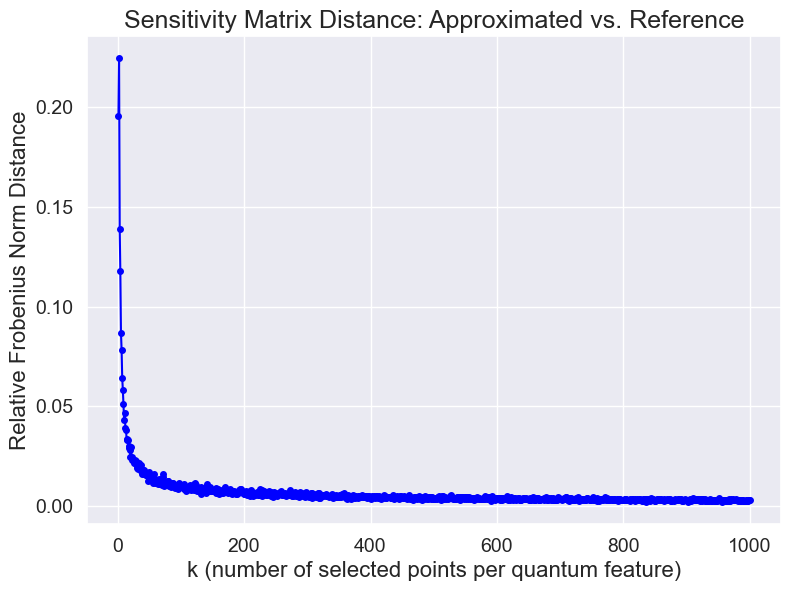

In [101]:
import matplotlib.pyplot as plt

def plot_distance_metrics(metrics, yscale="linear"):
    """
    Generates three plots based on the provided metrics.

    Parameters:
      metrics : dict
          Dictionary with the following keys:
            "k_values":              np.array of k values,
            "sensitivity_distances": np.array of relative Frobenius norm distances,
            "backprop_distances":    np.array of relative L2 norm distances,
            "order_distances":       np.array of order distances (1 - Spearman rank correlation).
      yscale : str, optional
          Scale for the y-axis in each plot ("linear" or "log"). Defaults to "linear".
    
    Produces:
      Three figures:
        1. Sensitivity Matrix Distance vs. k.
        2. Backpropagated Importances Distance vs. k.
        3. Order Distance vs. k.
    """
    k_values = metrics["k_values"]
    sens_dist = metrics["sensitivity_distances"]
    bp_dist = metrics["backprop_distances"]
    order_dist = metrics["order_distances"]
    
    # Common font sizes
    label_size = 16
    title_size = 18
    tick_size = 14
    marker_style = '.'  # Use point markers
    markersize = 8

    # Plot 1: Sensitivity Matrix Distance
    plt.figure(figsize=(8, 6))
    plt.plot(k_values, sens_dist, marker=marker_style, linestyle='-', color='blue', markersize=markersize)
    plt.xlabel("k (number of selected points per quantum feature)", fontsize=label_size)
    plt.ylabel("Relative Frobenius Norm Distance", fontsize=label_size)
    plt.title("Sensitivity Matrix Distance: Approximated vs. Reference", fontsize=title_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.grid(True)
    if yscale.lower() == "log":
        plt.yscale("log")
    plt.tight_layout()
    plt.show()

    # # Plot 2: Backpropagated Importances Distance
    # plt.figure(figsize=(8, 6))
    # plt.plot(k_values, bp_dist, marker=marker_style, linestyle='-', color='orange', markersize=markersize)
    # plt.xlabel("k (number of selected points per quantum feature)", fontsize=label_size)
    # plt.ylabel("Relative L2 Norm Distance", fontsize=label_size)
    # plt.title("Backpropagated Importances Distance: Approximated vs. Reference", fontsize=title_size)
    # plt.xticks(fontsize=tick_size)
    # plt.yticks(fontsize=tick_size)
    # plt.grid(True)
    # if yscale.lower() == "log":
    #     plt.yscale("log")
    # plt.tight_layout()
    # plt.show()

    # # Plot 3: Order Distance
    # plt.figure(figsize=(8, 6))
    # plt.plot(k_values, order_dist, marker=marker_style, linestyle='-', color='green', markersize=markersize)
    # plt.xlabel("k (number of selected points per quantum feature)", fontsize=label_size)
    # plt.ylabel("Order Distance (1 - Spearman Rank Correlation)", fontsize=label_size)
    # plt.title("Order Distance: Approximated vs. Reference Backpropagated Importances", fontsize=title_size)
    # plt.xticks(fontsize=tick_size)
    # plt.yticks(fontsize=tick_size)
    # plt.grid(True)
    # if yscale.lower() == "log":
    #     plt.yscale("symlog")
    # plt.tight_layout()
    # plt.show()

plot_distance_metrics(metrics_zoom, yscale="linear")  # or yscale="log"


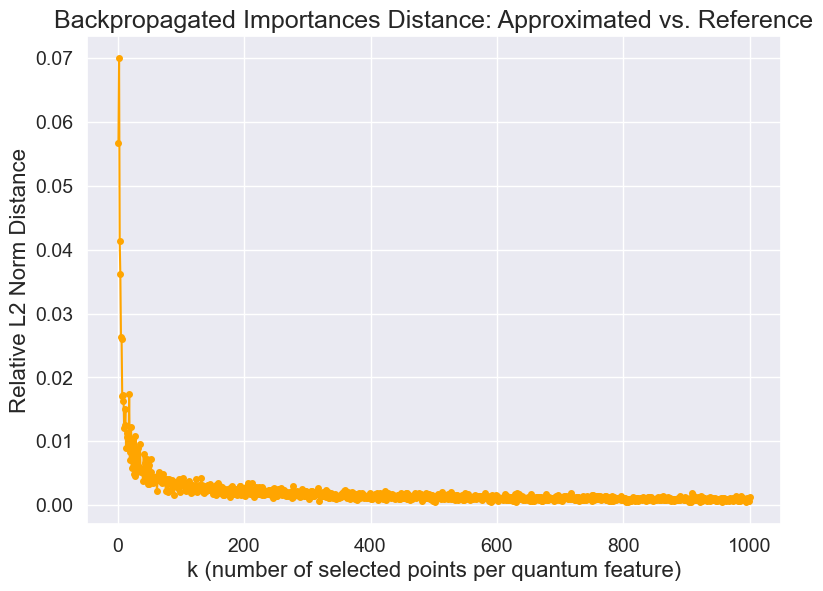

In [102]:
import matplotlib.pyplot as plt

def plot_distance_metrics(metrics, yscale="linear"):
    """
    Generates three plots based on the provided metrics.

    Parameters:
      metrics : dict
          Dictionary with the following keys:
            "k_values":              np.array of k values,
            "sensitivity_distances": np.array of relative Frobenius norm distances,
            "backprop_distances":    np.array of relative L2 norm distances,
            "order_distances":       np.array of order distances (1 - Spearman rank correlation).
      yscale : str, optional
          Scale for the y-axis in each plot ("linear" or "log"). Defaults to "linear".
    
    Produces:
      Three figures:
        1. Sensitivity Matrix Distance vs. k.
        2. Backpropagated Importances Distance vs. k.
        3. Order Distance vs. k.
    """
    k_values = metrics["k_values"]
    sens_dist = metrics["sensitivity_distances"]
    bp_dist = metrics["backprop_distances"]
    order_dist = metrics["order_distances"]
    
    # Common font sizes
    label_size = 16
    title_size = 18
    tick_size = 14
    marker_style = '.'  # Use point markers
    markersize = 8

    # # Plot 1: Sensitivity Matrix Distance
    # plt.figure(figsize=(8, 6))
    # plt.plot(k_values, sens_dist, marker=marker_style, linestyle='-', color='blue', markersize=markersize)
    # plt.xlabel("k (number of selected points per quantum feature)", fontsize=label_size)
    # plt.ylabel("Relative Frobenius Norm Distance", fontsize=label_size)
    # plt.title("Sensitivity Matrix Distance: Approximated vs. Reference", fontsize=title_size)
    # plt.xticks(fontsize=tick_size)
    # plt.yticks(fontsize=tick_size)
    # plt.grid(True)
    # if yscale.lower() == "log":
    #     plt.yscale("log")
    # plt.tight_layout()
    # plt.show()

    # Plot 2: Backpropagated Importances Distance
    plt.figure(figsize=(8, 6))
    plt.plot(k_values, bp_dist, marker=marker_style, linestyle='-', color='orange', markersize=markersize)
    plt.xlabel("k (number of selected points per quantum feature)", fontsize=label_size)
    plt.ylabel("Relative L2 Norm Distance", fontsize=label_size)
    plt.title("Backpropagated Importances Distance: Approximated vs. Reference", fontsize=title_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.grid(True)
    if yscale.lower() == "log":
        plt.yscale("log")
    plt.tight_layout()
    plt.show()

    # # Plot 3: Order Distance
    # plt.figure(figsize=(8, 6))
    # plt.plot(k_values, order_dist, marker=marker_style, linestyle='-', color='green', markersize=markersize)
    # plt.xlabel("k (number of selected points per quantum feature)", fontsize=label_size)
    # plt.ylabel("Order Distance (1 - Spearman Rank Correlation)", fontsize=label_size)
    # plt.title("Order Distance: Approximated vs. Reference Backpropagated Importances", fontsize=title_size)
    # plt.xticks(fontsize=tick_size)
    # plt.yticks(fontsize=tick_size)
    # plt.grid(True)
    # if yscale.lower() == "log":
    #     plt.yscale("symlog")
    # plt.tight_layout()
    # plt.show()

plot_distance_metrics(metrics_zoom, yscale="linear")  # or yscale="log"


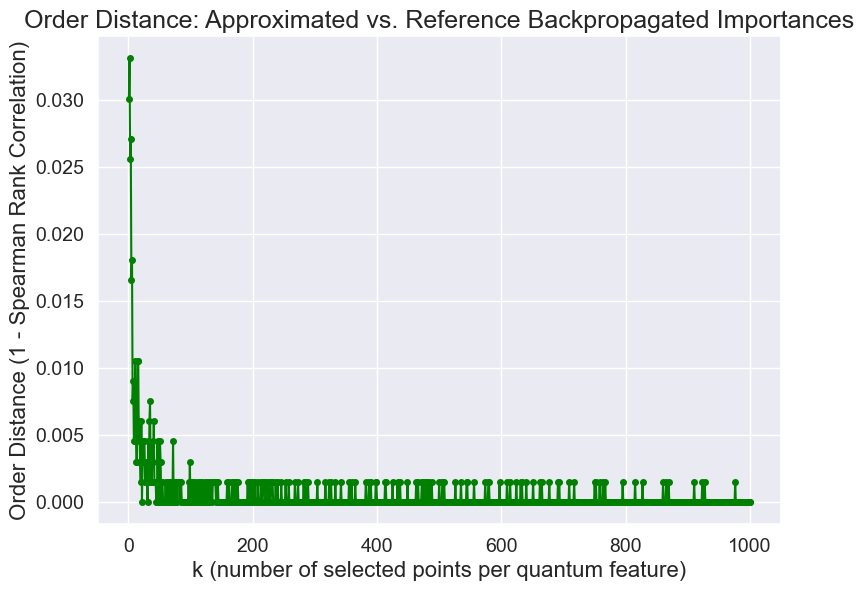

In [103]:
import matplotlib.pyplot as plt

def plot_distance_metrics(metrics, yscale="linear"):
    """
    Generates three plots based on the provided metrics.

    Parameters:
      metrics : dict
          Dictionary with the following keys:
            "k_values":              np.array of k values,
            "sensitivity_distances": np.array of relative Frobenius norm distances,
            "backprop_distances":    np.array of relative L2 norm distances,
            "order_distances":       np.array of order distances (1 - Spearman rank correlation).
      yscale : str, optional
          Scale for the y-axis in each plot ("linear" or "log"). Defaults to "linear".
    
    Produces:
      Three figures:
        1. Sensitivity Matrix Distance vs. k.
        2. Backpropagated Importances Distance vs. k.
        3. Order Distance vs. k.
    """
    k_values = metrics["k_values"]
    sens_dist = metrics["sensitivity_distances"]
    bp_dist = metrics["backprop_distances"]
    order_dist = metrics["order_distances"]
    
    # Common font sizes
    label_size = 16
    title_size = 18
    tick_size = 14
    marker_style = '.'  # Use point markers
    markersize = 8

    # # Plot 1: Sensitivity Matrix Distance
    # plt.figure(figsize=(8, 6))
    # plt.plot(k_values, sens_dist, marker=marker_style, linestyle='-', color='blue', markersize=markersize)
    # plt.xlabel("k (number of selected points per quantum feature)", fontsize=label_size)
    # plt.ylabel("Relative Frobenius Norm Distance", fontsize=label_size)
    # plt.title("Sensitivity Matrix Distance: Approximated vs. Reference", fontsize=title_size)
    # plt.xticks(fontsize=tick_size)
    # plt.yticks(fontsize=tick_size)
    # plt.grid(True)
    # if yscale.lower() == "log":
    #     plt.yscale("log")
    # plt.tight_layout()
    # plt.show()

    # # Plot 2: Backpropagated Importances Distance
    # plt.figure(figsize=(8, 6))
    # plt.plot(k_values, bp_dist, marker=marker_style, linestyle='-', color='orange', markersize=markersize)
    # plt.xlabel("k (number of selected points per quantum feature)", fontsize=label_size)
    # plt.ylabel("Relative L2 Norm Distance", fontsize=label_size)
    # plt.title("Backpropagated Importances Distance: Approximated vs. Reference", fontsize=title_size)
    # plt.xticks(fontsize=tick_size)
    # plt.yticks(fontsize=tick_size)
    # plt.grid(True)
    # if yscale.lower() == "log":
    #     plt.yscale("log")
    # plt.tight_layout()
    # plt.show()

    # Plot 3: Order Distance
    plt.figure(figsize=(8, 6))
    plt.plot(k_values, order_dist, marker=marker_style, linestyle='-', color='green', markersize=markersize)
    plt.xlabel("k (number of selected points per quantum feature)", fontsize=label_size)
    plt.ylabel("Order Distance (1 - Spearman Rank Correlation)", fontsize=label_size)
    plt.title("Order Distance: Approximated vs. Reference Backpropagated Importances", fontsize=title_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.grid(True)
    if yscale.lower() == "log":
        plt.yscale("symlog")
    plt.tight_layout()
    plt.show()

plot_distance_metrics(metrics_zoom, yscale="linear")  # or yscale="log"


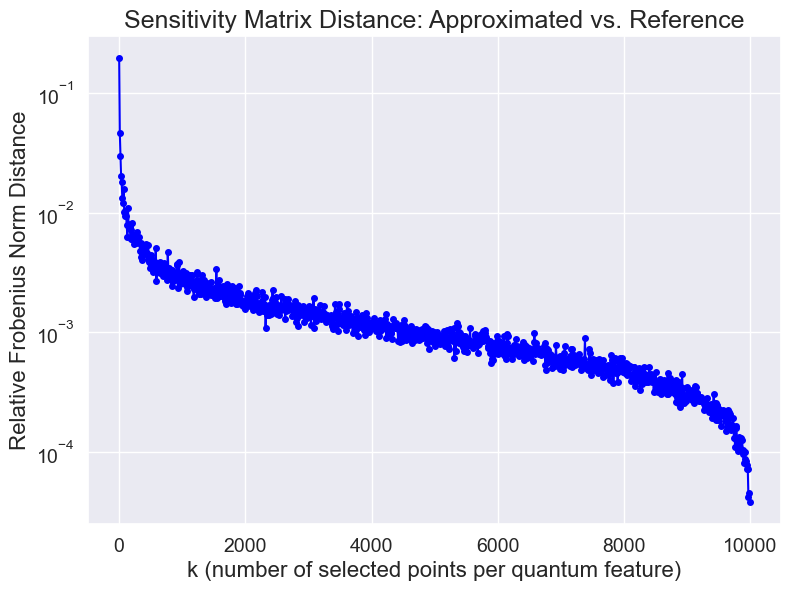

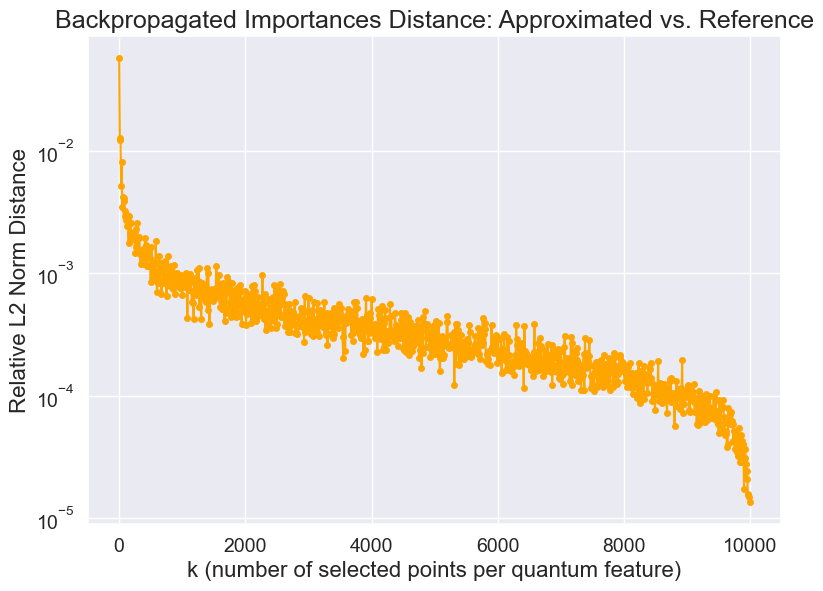

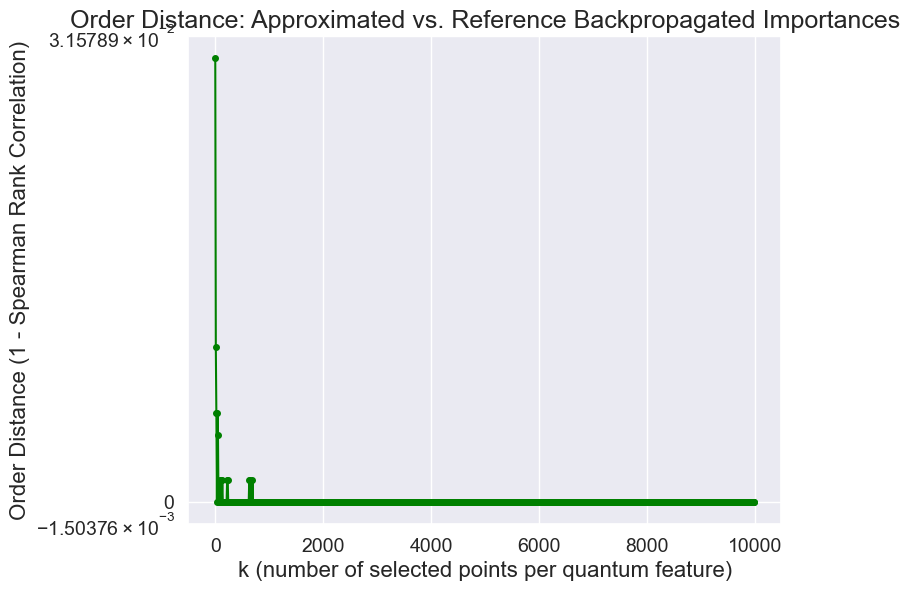

In [84]:
plot_distance_metrics(metrics, yscale="log")

In [75]:
metrics["order_distances"][:1000]

array([0.03007519, 0.01052632, 0.00601504, 0.        , 0.00601504,
       0.00451128, 0.        , 0.        , 0.00150376, 0.        ,
       0.00150376, 0.        , 0.        , 0.00150376, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00150376, 0.00150376, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00150376, 0.        ,
       0.00150376, 0.        , 0.        , 0.        , 0.00150376,
       0.        , 0.        , 0.        , 0.        , 0.     

# Run k from 1 up to 1000 in step of 1

In [79]:
import os
import time
import pickle
import pandas as pd

alpha = 0.1  
  
shifted_data_dir = "shifted_data"  

# Create a folder to store all results (if it doesn't exist already)
results_folder = "sensitivity_results_zoom_1_1000"
os.makedirs(results_folder, exist_ok=True)

# Loop over k values from 1 to 10,000 in steps of 1
for k_val in range(1, 1001, 1):
    start_time = time.time()
    print(f"\nComputing for k = {k_val} ...")
    
    # Compute the approximate sensitivity matrix
    S_approx = compute_approx_sensitivity_matrix(alpha, k_val, shifted_data_dir, df_quantum)
    S_approx_df = pd.DataFrame(S_approx,
                               index=[f"theta_{i}" for i in range(S_approx.shape[0])],
                               columns=quantum_feature_names)
    
    # Compute backpropagated feature importances
    backprop_importances = S_approx_df.dot(quantum_importances)
    
    # Save both results in a dictionary
    results_dict = {
        "S_approx": S_approx_df,
        "backprop_importances": backprop_importances
    }
    
    # Build filename that includes the k value
    filename = f"results_k_{k_val}.pkl"
    filepath = os.path.join(results_folder, filename)
    
    # Save the dictionary as a pickle file
    with open(filepath, "wb") as f:
        pickle.dump(results_dict, f)
    
    elapsed_time = time.time() - start_time
    print(f"Finished k = {k_val} in {elapsed_time:.2f} seconds; file saved as: {filename}")



Computing for k = 1 ...
Finished k = 1 in 0.24 seconds; file saved as: results_k_1.pkl

Computing for k = 2 ...
Finished k = 2 in 0.19 seconds; file saved as: results_k_2.pkl

Computing for k = 3 ...
Finished k = 3 in 0.22 seconds; file saved as: results_k_3.pkl

Computing for k = 4 ...
Finished k = 4 in 0.22 seconds; file saved as: results_k_4.pkl

Computing for k = 5 ...
Finished k = 5 in 0.22 seconds; file saved as: results_k_5.pkl

Computing for k = 6 ...
Finished k = 6 in 0.22 seconds; file saved as: results_k_6.pkl

Computing for k = 7 ...
Finished k = 7 in 0.23 seconds; file saved as: results_k_7.pkl

Computing for k = 8 ...
Finished k = 8 in 0.22 seconds; file saved as: results_k_8.pkl

Computing for k = 9 ...
Finished k = 9 in 0.22 seconds; file saved as: results_k_9.pkl

Computing for k = 10 ...
Finished k = 10 in 0.23 seconds; file saved as: results_k_10.pkl

Computing for k = 11 ...
Finished k = 11 in 0.22 seconds; file saved as: results_k_11.pkl

Computing for k = 12 ...


# Analysis plots zoom

In [85]:

metrics_zoom = compute_distance_metrics(S_ref, "sensitivity_results_zoom_1_1000", quantum_importances)

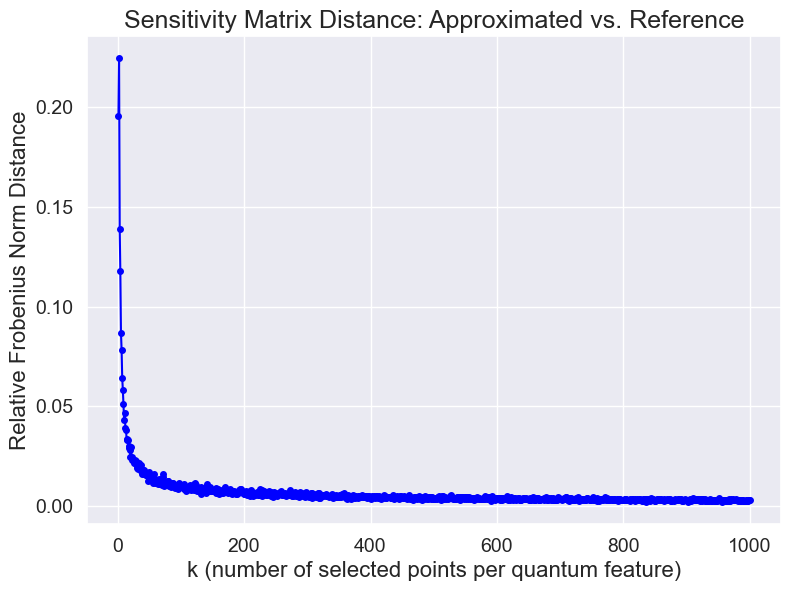

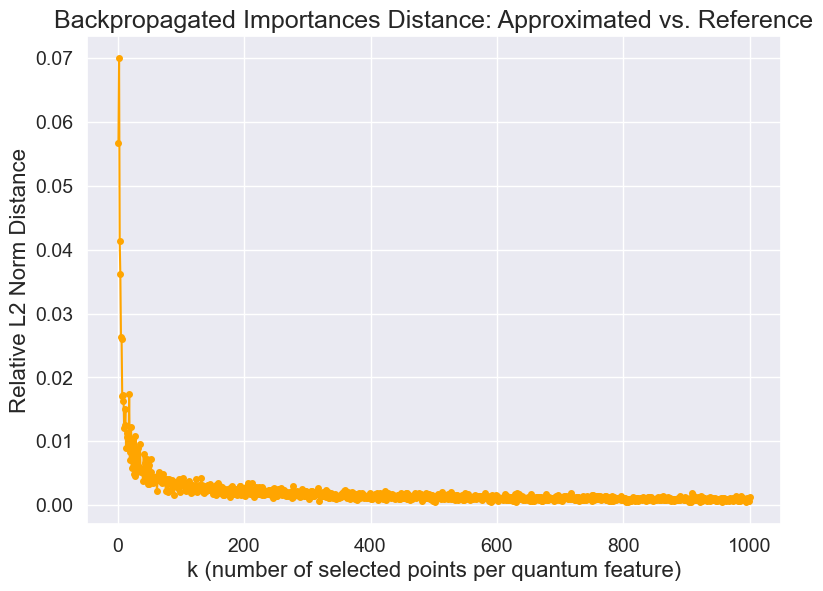

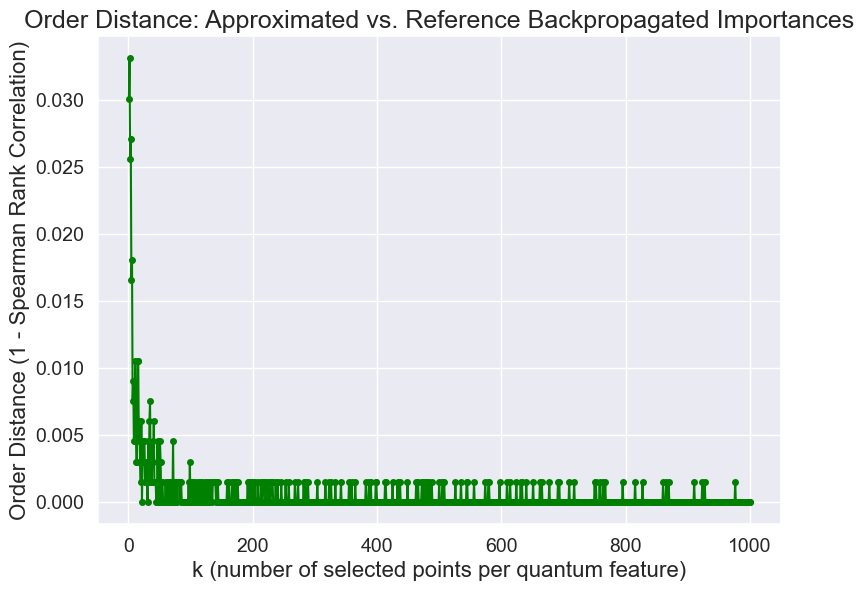

In [86]:
plot_distance_metrics(metrics_zoom, yscale="linear")

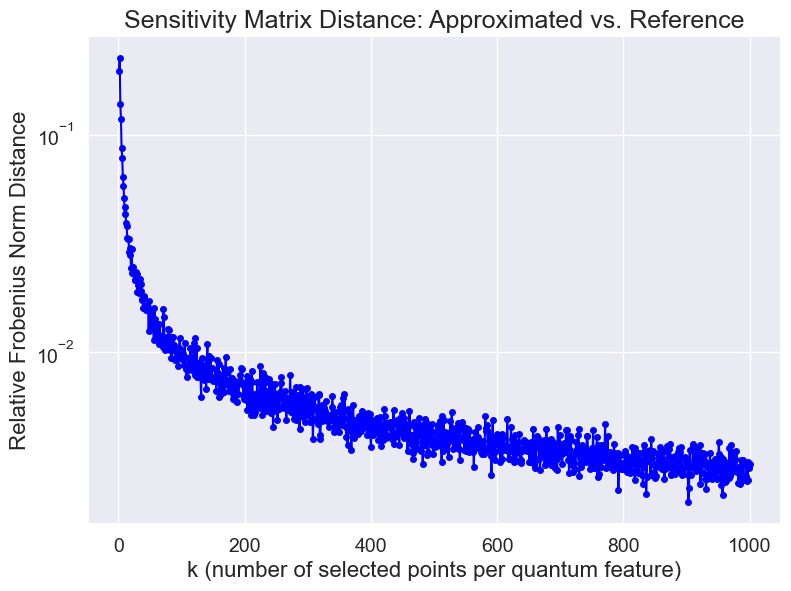

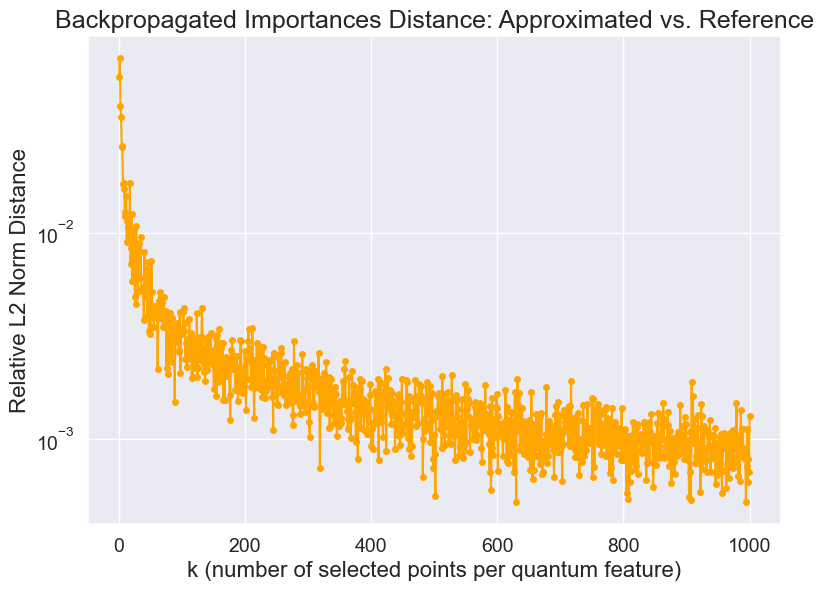

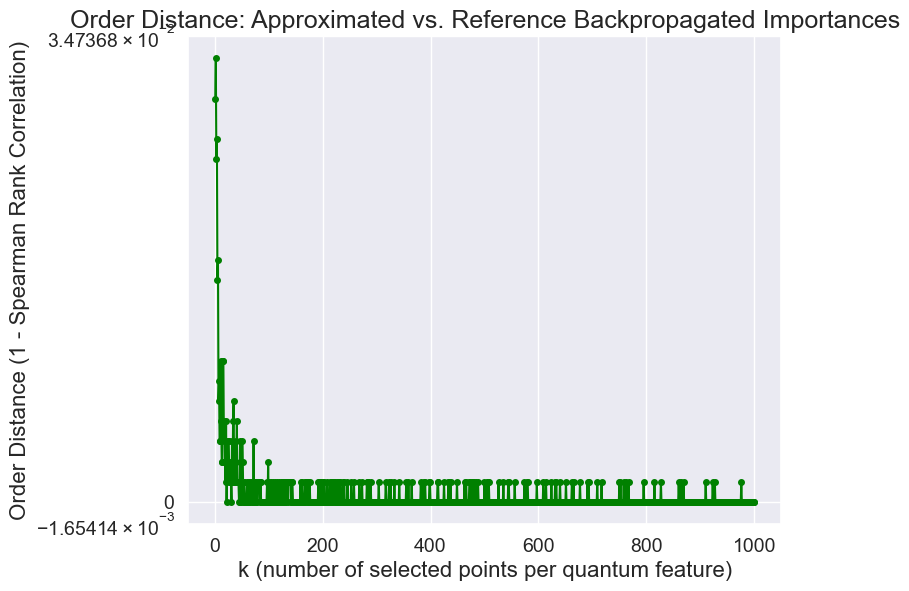

In [87]:
plot_distance_metrics(metrics_zoom, yscale="log")

# Compare feature importances

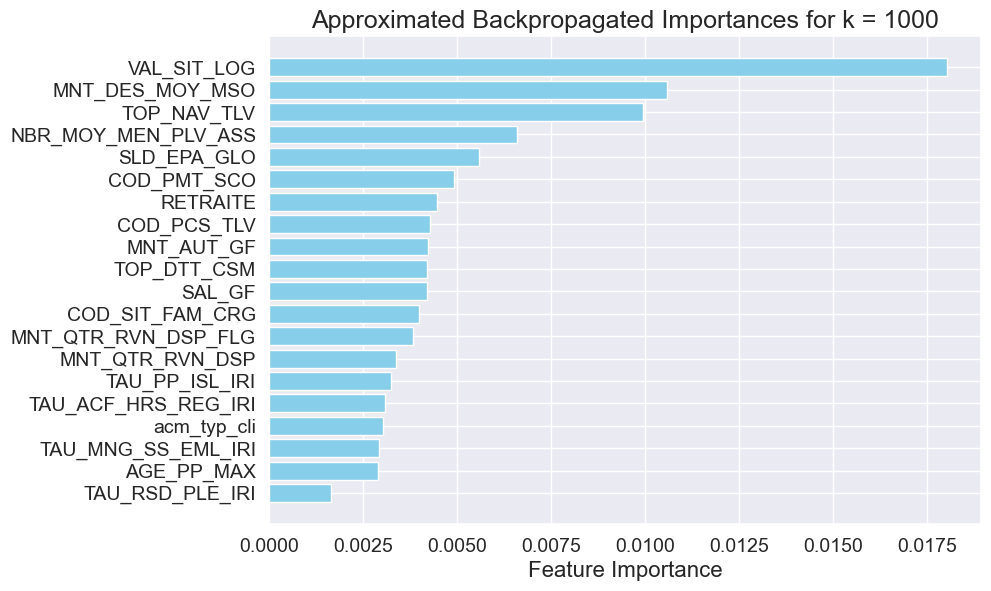

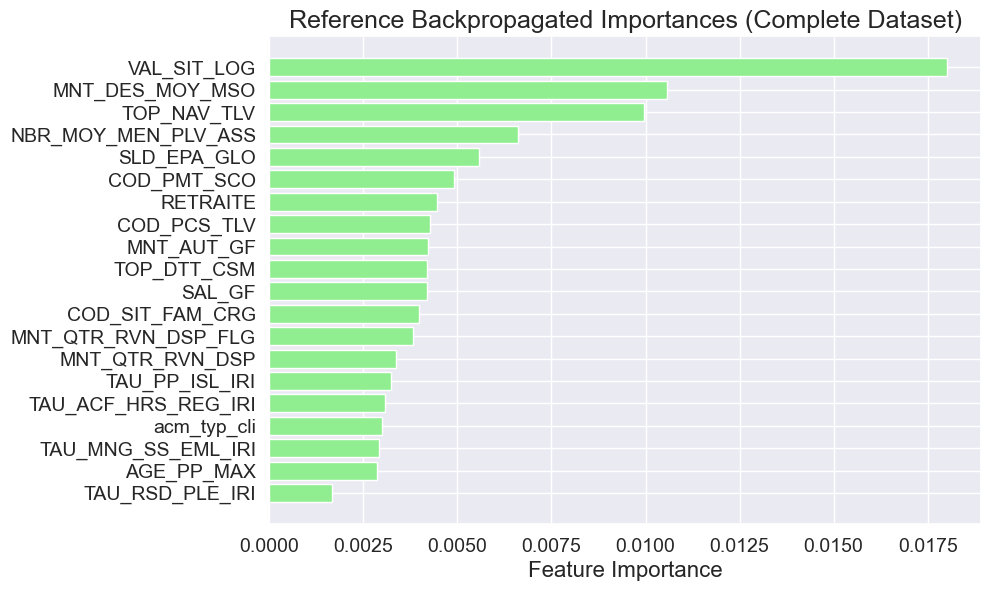

In [89]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt

def plot_backprop_importances(chosen_k, quantum_importances,
                              orig_data_file="data_homiris/X_train_int_sample.csv",
                              results_folder="sensitivity_results",
                              sensitivity_matrix_file="sensitivity_matrix.pkl"):
    """
    For a given chosen k, load the approximated backpropagated importances and the reference
    backpropagated importances, then plot them in two separate horizontal bar charts.
    
    Parameters:
      chosen_k : int
          The value of k for which to plot the approximated results.
      quantum_importances : np.ndarray
          The vector of quantum feature importances (used to compute backpropagated importances).
      orig_data_file : str
          Path to the original training data CSV file to extract original feature names.
      results_folder : str
          Folder where the approximated results (pickle files) are stored.
      sensitivity_matrix_file : str
          Path to the pickle file containing the reference sensitivity matrix.
    """
    # Load the original dataset to get the original feature names.
    df_orig = pd.read_csv(orig_data_file, delimiter=';', dtype=float)
    original_feature_names = df_orig.columns.tolist()
    
    # Load the reference sensitivity matrix and compute reference backpropagated importances.
    with open(sensitivity_matrix_file, "rb") as f:
        S_ref = pickle.load(f)  # Expected to be a DataFrame
    backprop_ref = S_ref.dot(quantum_importances)
    
    # Load the approximated results for the chosen k.
    approx_file = os.path.join(results_folder, f"results_k_{chosen_k}.pkl")
    with open(approx_file, "rb") as f:
        results_dict = pickle.load(f)
    backprop_approx = results_dict["backprop_importances"]
    
    # Create a DataFrame for the approximated backpropagated importances.
    importance_df_approx = pd.DataFrame({
        "feature": original_feature_names,
        "importance": backprop_approx
    }).sort_values(by="importance", ascending=False)
    
    # Create a DataFrame for the reference backpropagated importances.
    importance_df_ref = pd.DataFrame({
        "feature": original_feature_names,
        "importance": backprop_ref
    }).sort_values(by="importance", ascending=False)
    
    # Plot the approximated backpropagated importances.
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df_approx["feature"], importance_df_approx["importance"], color='skyblue')
    plt.xlabel("Feature Importance", fontsize=16)
    plt.title(f"Approximated Backpropagated Importances for k = {chosen_k}", fontsize=18)
    plt.gca().invert_yaxis()  # Most important features on top.
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Plot the reference backpropagated importances.
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df_ref["feature"], importance_df_ref["importance"], color='lightgreen')
    plt.xlabel("Feature Importance", fontsize=16)
    plt.title("Reference Backpropagated Importances (Complete Dataset)", fontsize=18)
    plt.gca().invert_yaxis()
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

# === Example usage ===
# Make sure that quantum_importances is defined in your workspace, for example:
# quantum_importances = xgb_model.feature_importances_
#
# Then call the function with your desired k value:
plot_backprop_importances(chosen_k=1000, quantum_importances=quantum_importances, results_folder="sensitivity_results_zoom_1_1000")


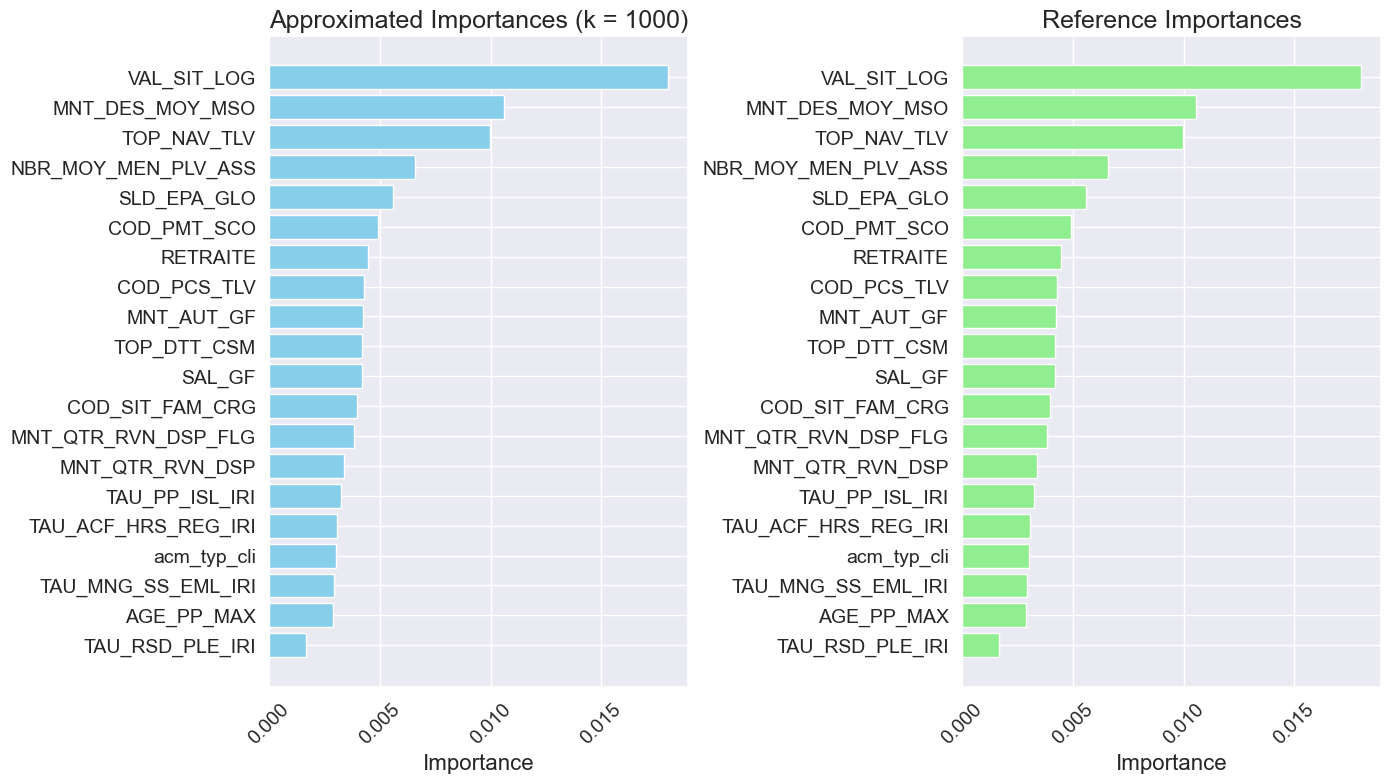

In [91]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt

def plot_combined_backprop_importances(chosen_k, quantum_importances,
                                       orig_data_file="data_homiris/X_train_int_sample.csv",
                                       results_folder="sensitivity_results",
                                       sensitivity_matrix_file="sensitivity_matrix.pkl"):
    """
    For a given chosen k, load the approximated and reference backpropagated importances,
    and plot them in one figure with two subplots (side-by-side).
    
    The original feature names are obtained from the original dataset.
    
    Parameters:
      chosen_k : int
          The value of k for which to load the approximated results.
      quantum_importances : np.ndarray
          The vector of quantum feature importances (e.g., from your XGBoost model).
      orig_data_file : str
          Path to the original CSV file (used to obtain the original feature names).
      results_folder : str
          Folder where the approximated results pickle files are stored.
      sensitivity_matrix_file : str
          Path to the pickle file containing the reference sensitivity matrix.
    """
    # Load original dataset to obtain feature names.
    df_orig = pd.read_csv(orig_data_file, delimiter=';', dtype=float)
    original_feature_names = df_orig.columns.tolist()
    
    # Load the reference sensitivity matrix and compute reference backpropagated importances.
    with open(sensitivity_matrix_file, "rb") as f:
        S_ref = pickle.load(f)  # Expected to be a DataFrame with original features as index
    backprop_ref = S_ref.dot(quantum_importances)
    
    # Load the approximated results for the chosen k.
    approx_file = os.path.join(results_folder, f"results_k_{chosen_k}.pkl")
    with open(approx_file, "rb") as f:
        results_dict = pickle.load(f)
    backprop_approx = results_dict["backprop_importances"]
    
    # Create DataFrames for easier plotting.
    # Sorting in descending order so that after inverting the y-axis the highest importance is at the top.
    importance_df_approx = pd.DataFrame({
        "feature": original_feature_names,
        "importance": backprop_approx
    }).sort_values(by="importance", ascending=False)
    
    importance_df_ref = pd.DataFrame({
        "feature": original_feature_names,
        "importance": backprop_ref
    }).sort_values(by="importance", ascending=False)
    
    # Define font sizes for readability.
    label_size = 16
    title_size = 18
    tick_size = 14

    # Create one figure with two subplots (side-by-side).
    fig, ax = plt.subplots(1, 2, figsize=(14, 8))
    
    # Subplot 1: Approximated Backpropagated Importances.
    ax[0].barh(importance_df_approx["feature"], importance_df_approx["importance"], color='skyblue')
    ax[0].set_xlabel("Importance", fontsize=label_size)
    ax[0].set_title(f"Approximated Importances (k = {chosen_k})", fontsize=title_size)
    ax[0].invert_yaxis()  # Invert so that highest importance appears at the top.
    ax[0].tick_params(axis='x', labelsize=tick_size, rotation=45)
    ax[0].tick_params(axis='y', labelsize=tick_size)
    
    # Subplot 2: Reference Backpropagated Importances.
    ax[1].barh(importance_df_ref["feature"], importance_df_ref["importance"], color='lightgreen')
    ax[1].set_xlabel("Importance", fontsize=label_size)
    ax[1].set_title("Reference Importances", fontsize=title_size)
    ax[1].invert_yaxis()
    ax[1].tick_params(axis='x', labelsize=tick_size, rotation=45)
    ax[1].tick_params(axis='y', labelsize=tick_size)
    
    fig.tight_layout()
    plt.show()
    
plot_combined_backprop_importances(chosen_k=1000, quantum_importances=quantum_importances, results_folder="sensitivity_results_zoom_1_1000")


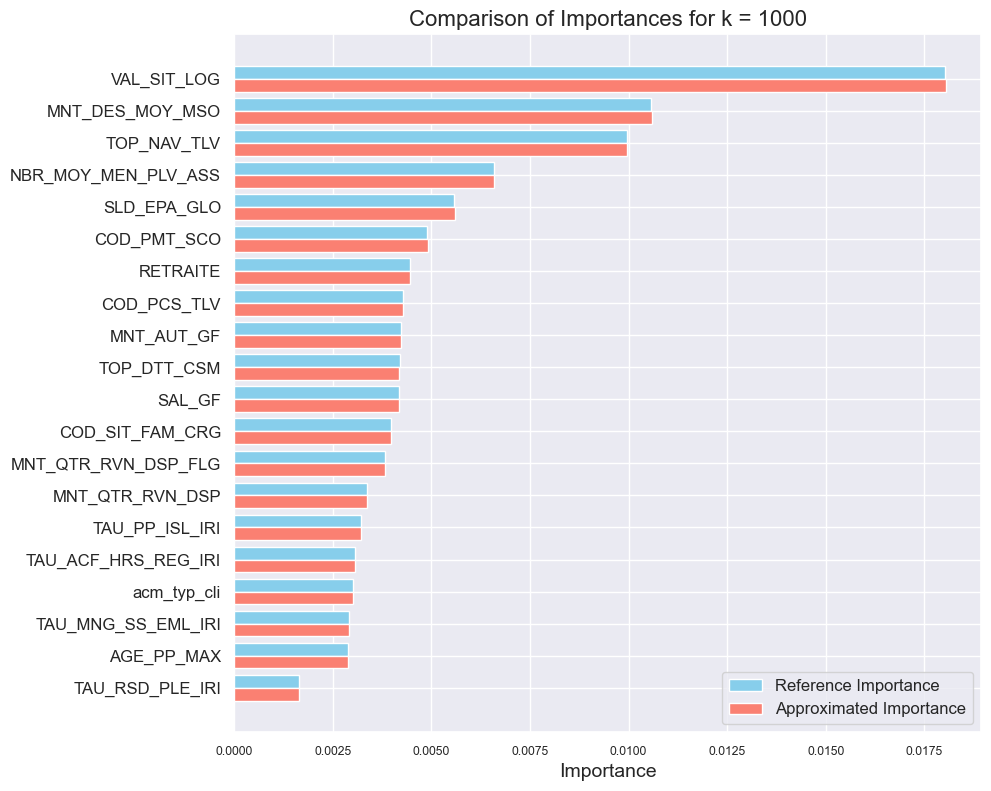

In [97]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_combined_importances(chosen_k, quantum_importances,
                              orig_data_file="data_homiris/X_train_int_sample.csv",
                              results_folder="sensitivity_results",
                              sensitivity_matrix_file="sensitivity_matrix.pkl"):
    """
    For a given chosen k, load the reference and approximated backpropagated importances,
    then create a single combined horizontal bar plot showing both sets of importances side-by-side.
    
    Parameters:
      chosen_k : int
          The value of k for which to load the approximated results.
      quantum_importances : np.ndarray
          The vector of quantum feature importances (e.g., from your XGBoost model).
      orig_data_file : str
          Path to the original CSV file to obtain original feature names.
      results_folder : str
          Folder where the approximated results pickle files are stored.
      sensitivity_matrix_file : str
          Path to the pickle file containing the reference sensitivity matrix.
    """
    # Load the original dataset to get original feature names.
    df_orig = pd.read_csv(orig_data_file, delimiter=';', dtype=float)
    feature_names = df_orig.columns.tolist()
    
    # Load the reference sensitivity matrix and compute reference importances.
    with open(sensitivity_matrix_file, "rb") as f:
        S_ref = pickle.load(f)  # Expected to be a DataFrame with original features as index
    backprop_ref = S_ref.dot(quantum_importances)
    
    # Load the approximated results for the chosen k.
    approx_file = os.path.join(results_folder, f"results_k_{chosen_k}.pkl")
    with open(approx_file, "rb") as f:
        results_dict = pickle.load(f)
    backprop_approx = results_dict["backprop_importances"]
    
    # Create a comparison DataFrame with both sets of importances.
    comparison_df = pd.DataFrame({
        "feature": feature_names,
        "reference_importance": backprop_ref,
        "backprop_importance": backprop_approx
    })
    
    # Sort by the reference importance in descending order so that the highest importance is on top.
    comparison_df = comparison_df.sort_values(by="reference_importance", ascending=False)
    
    # Prepare for plotting.
    indices = np.arange(len(comparison_df))
    bar_width = 0.4
    
    plt.figure(figsize=(10, 8))
    plt.barh(indices - bar_width/2, comparison_df["reference_importance"], height=bar_width,
             label="Reference Importance", color="skyblue")
    plt.barh(indices + bar_width/2, comparison_df["backprop_importance"], height=bar_width,
             label="Approximated Importance", color="salmon")
    
    plt.yticks(indices, comparison_df["feature"], fontsize=12)
    plt.xlabel("Importance", fontsize=14)
    plt.title(f"Comparison of Importances for k = {chosen_k}", fontsize=16)
    plt.legend(fontsize=12)
    plt.gca().invert_yaxis()  # Ensure highest importance is at the top.
    plt.tight_layout()
    plt.show()

plot_combined_importances(chosen_k=1000, quantum_importances=quantum_importances, results_folder="sensitivity_results_zoom_1_1000")
